**The Relationship between Bank Term Subscriptions, Age and Bank Balance**

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in library(themis): there is no package called ‘themis’


**Introduction**<br/>
The Bank Marketing dataset was gathered from a direct marketing campaign of a Portuguese baking institution. The bank collected information from their clients over the phone, and each client was contacted multiple times. The Bank Marketing Dataset discusses multiple characteristics of each client of a bank in hopes to predict whether they will subscribe to a term deposit. In simplest terms, a bank term deposit is depositing a certain sum of money and keeping it in the bank for a specific period of time. The information collected in the dataset includes age, job, education, marital status, balance, education, and housing to name a few.

The question our project aims to answer is: Will new clients subscribe or not subscribe to a bank term deposit? A K-nearest classifier was built to answer this question.


**Methods**<br/>
A preliminary data analysis was completed to review the information, available to us, to work with as well as choose the main predictors to use for the project. The two predictors chosen for the project were age and balance. 

The dataset was first loaded into R from an external website and converted into a .csv file format to ensure that it can be worked with efficiently. The functions head and tail were used to show snippets of the dataset to ensure readability. The select function was then used on the bank dataset to extract the columns we are interested in working with: age, balance and y. The data was then split using the function inital_split. The training set (bank_train) and testing (bank_test) were created to be used for training and testing respectively.
We then created a scatter plot of the unscaled age and and balance. Red and blue data points were used to denote whether or not someone subscribed to a bank term deposit. This was done as part of our initial exploratory analysis.

**Table 1.0 - Bank Data**

In [3]:
temp <- tempfile()
temp2 <- tempfile()

# Load the data from source website
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

download.file(url, temp)
unzip(zipfile = temp, exdir = temp2)
# Read the data as csv and treat the variable "y(whether client subscribe to term deposit)" as factor
bank_data <- read_csv2(file.path(temp2, "bank.csv")) %>%
    mutate(y = as_factor(y))
unlink(c(temp, temp2))
head(bank_data)
tail(bank_data)

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  age = col_double(),
  job = col_character(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  balance = col_double(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  day = col_double(),
  month = col_character(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  y = col_character()
)



age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
35,management,single,tertiary,no,747,no,no,cellular,23,feb,141,2,176,3,failure,no


age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
32,services,single,secondary,no,473,yes,no,cellular,7,jul,624,5,-1,0,unknown,no
33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


**Table 1.1 - Selected Columns of Bank Data**

In [17]:
# Extract a data frame from the original data with only the columns we are interested in
bank_age_balance <- bank_data %>% select(age,balance,y)
# Print the head and tail of the bank_age_balance
head(bank_age_balance)
tail(bank_age_balance)

age,balance,y
<dbl>,<dbl>,<fct>
30,1787,no
33,4789,no
35,1350,no
30,1476,no
59,0,no
35,747,no


age,balance,y
<dbl>,<dbl>,<fct>
32,473,no
33,-333,no
57,-3313,no
57,295,no
28,1137,no
44,1136,no


**Table 2 - Split of Data**

In [18]:
# Splitting the data into training data and testing data
bank_split <- initial_split(bank_age_balance, prop = 0.75, strata = age)  
# We choose 0.75 as the portion of training data because we will perform cross-validation later,
# so the training data set cannot be too small. However we also think that the testing on
# the accuracy of our model is important, so we believe that 0.75 is an appropriate choise.
bank_train <- training(bank_split)   
bank_test <- testing(bank_split)

# Print the head and tail of the training set
head(bank_train)
tail(bank_train)

age,balance,y
<dbl>,<dbl>,<fct>
33,4789,no
35,1350,no
30,1476,no
59,0,no
35,747,no
36,307,no


age,balance,y
<dbl>,<dbl>,<fct>
49,322,no
38,1205,no
32,473,no
33,-333,no
57,295,no
28,1137,no


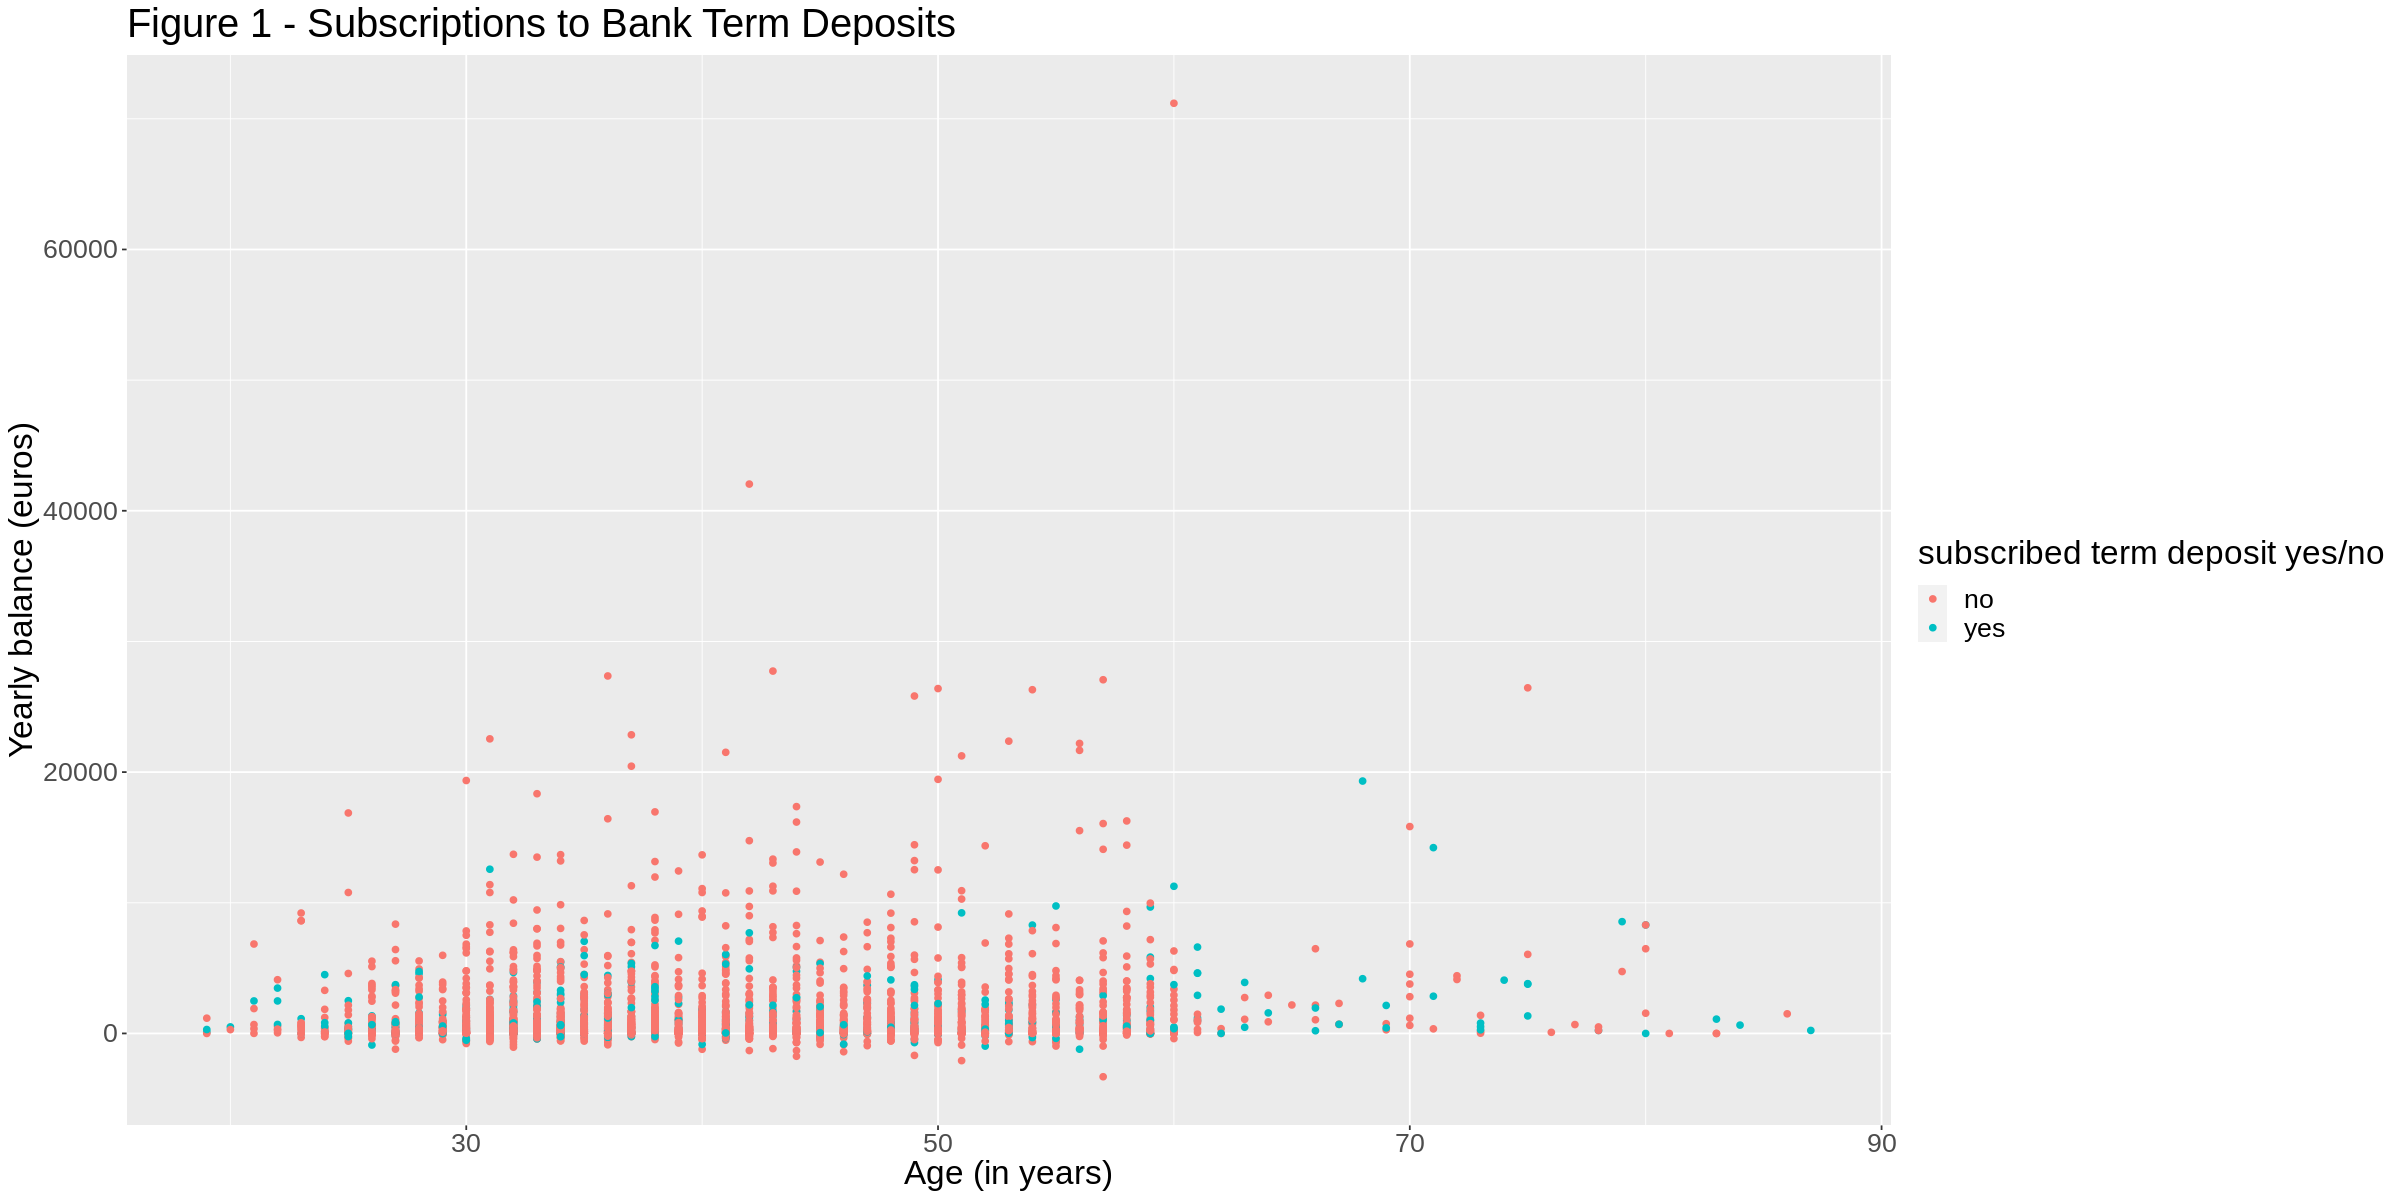

In [8]:
# We first plot a scatterplot on age vs balance
# with the factor y colored on every single points.

options(repr.plot.width = 20, repr.plot.height = 10) 
age_vs_balance_plot <- bank_train %>%
    ggplot(aes(x = age, y = balance)) +
    geom_point(aes(colour = y)) + 
    labs(x = "Age (in years)", y = "Yearly balance (euros)",
        colour = "subscribed term deposit yes/no") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 1 - Subscriptions to Bank Term Deposits")
age_vs_balance_plot

**Methods (continued)**<br/>
As the scale of the predictors could negatively impact the results, the data was scaled to mitigate these effects. We began the data preprocessing by initializing a recipe for the unscaled bank_train data frame. We then scaled and centered the data using the functions prep() to finalize the recipe step and bake() to apply the scaling and centering to the data. A new plot with the scaled age and balance data was created.

The K-nearest neighbors classifier was then created with the scaled training set (scaled_bank) and age and balance as predictors. The class labels for the test set were then predicted using the classifier. Then the accuracy of the classifier was assessed using the metrics function which was found to be 88.2%. A new plot of the Neighbors on the x-axis and the Accuracies on the y-axis was then created so that we could visualize the K that gives the best accuracy; it is K=12. 


**Table 3 - Scaled and Centered Training Data**

In [20]:
baked_training <- recipe(y ~ ., data = bank_train) %>%
    step_normalize(age) %>%
    step_upsample(y, over_ratio = 1, skip = FALSE) %>%
    prep() %>%
    bake(bank_train)

dummy_recipe <- recipe(y ~ ., data = bank_train)

head(baked_training)
tail(baked_training)

age,balance,y
<dbl>,<dbl>,<fct>
-0.7713969,4789,no
-0.5822968,1350,no
-1.0550470,1476,no
1.6869045,0,no
-0.5822968,747,no
-0.4877467,307,no


age,balance,y
<dbl>,<dbl>,<fct>
1.1196042,732,yes
-1.0550470,-522,yes
-1.0550470,569,yes
1.3087043,1580,yes
-0.4877467,480,yes
3.0106053,796,yes


In [22]:
# Initializing a recipe for the unscaled bank_train data frame
bank_recipe <- recipe(y ~ age + balance, data = bank_train)
bank_recipe 

# Scaling and centering all the given predictors
bank_recipe_scaled <- bank_recipe %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>%
    prep()
bank_recipe_scaled

# Final step to scaling and centering the data by applying the bake function
# to the unscaled data
scaled_bank <- bake(bank_recipe_scaled, bank_train)
head(scaled_bank)
tail(scaled_bank)

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Training data contained 3392 data points and no missing data.

Operations:

Scaling for age, balance [trained]
Centering for age, balance [trained]

age,balance,y
<dbl>,<dbl>,<fct>
-0.7713969,1.026905891,no
-0.5822968,-0.045170900,no
-1.0550470,-0.005891553,no
1.6869045,-0.466021051,no
-0.5822968,-0.233150634,no
-0.4877467,-0.370316609,no


age,balance,y
<dbl>,<dbl>,<fct>
0.7414040,-0.36564050,no
-0.2986466,-0.09037332,no
-0.8659469,-0.31856763,no
-0.7713969,-0.56983075,no
1.4978044,-0.37405750,no
-1.2441472,-0.11157170,no


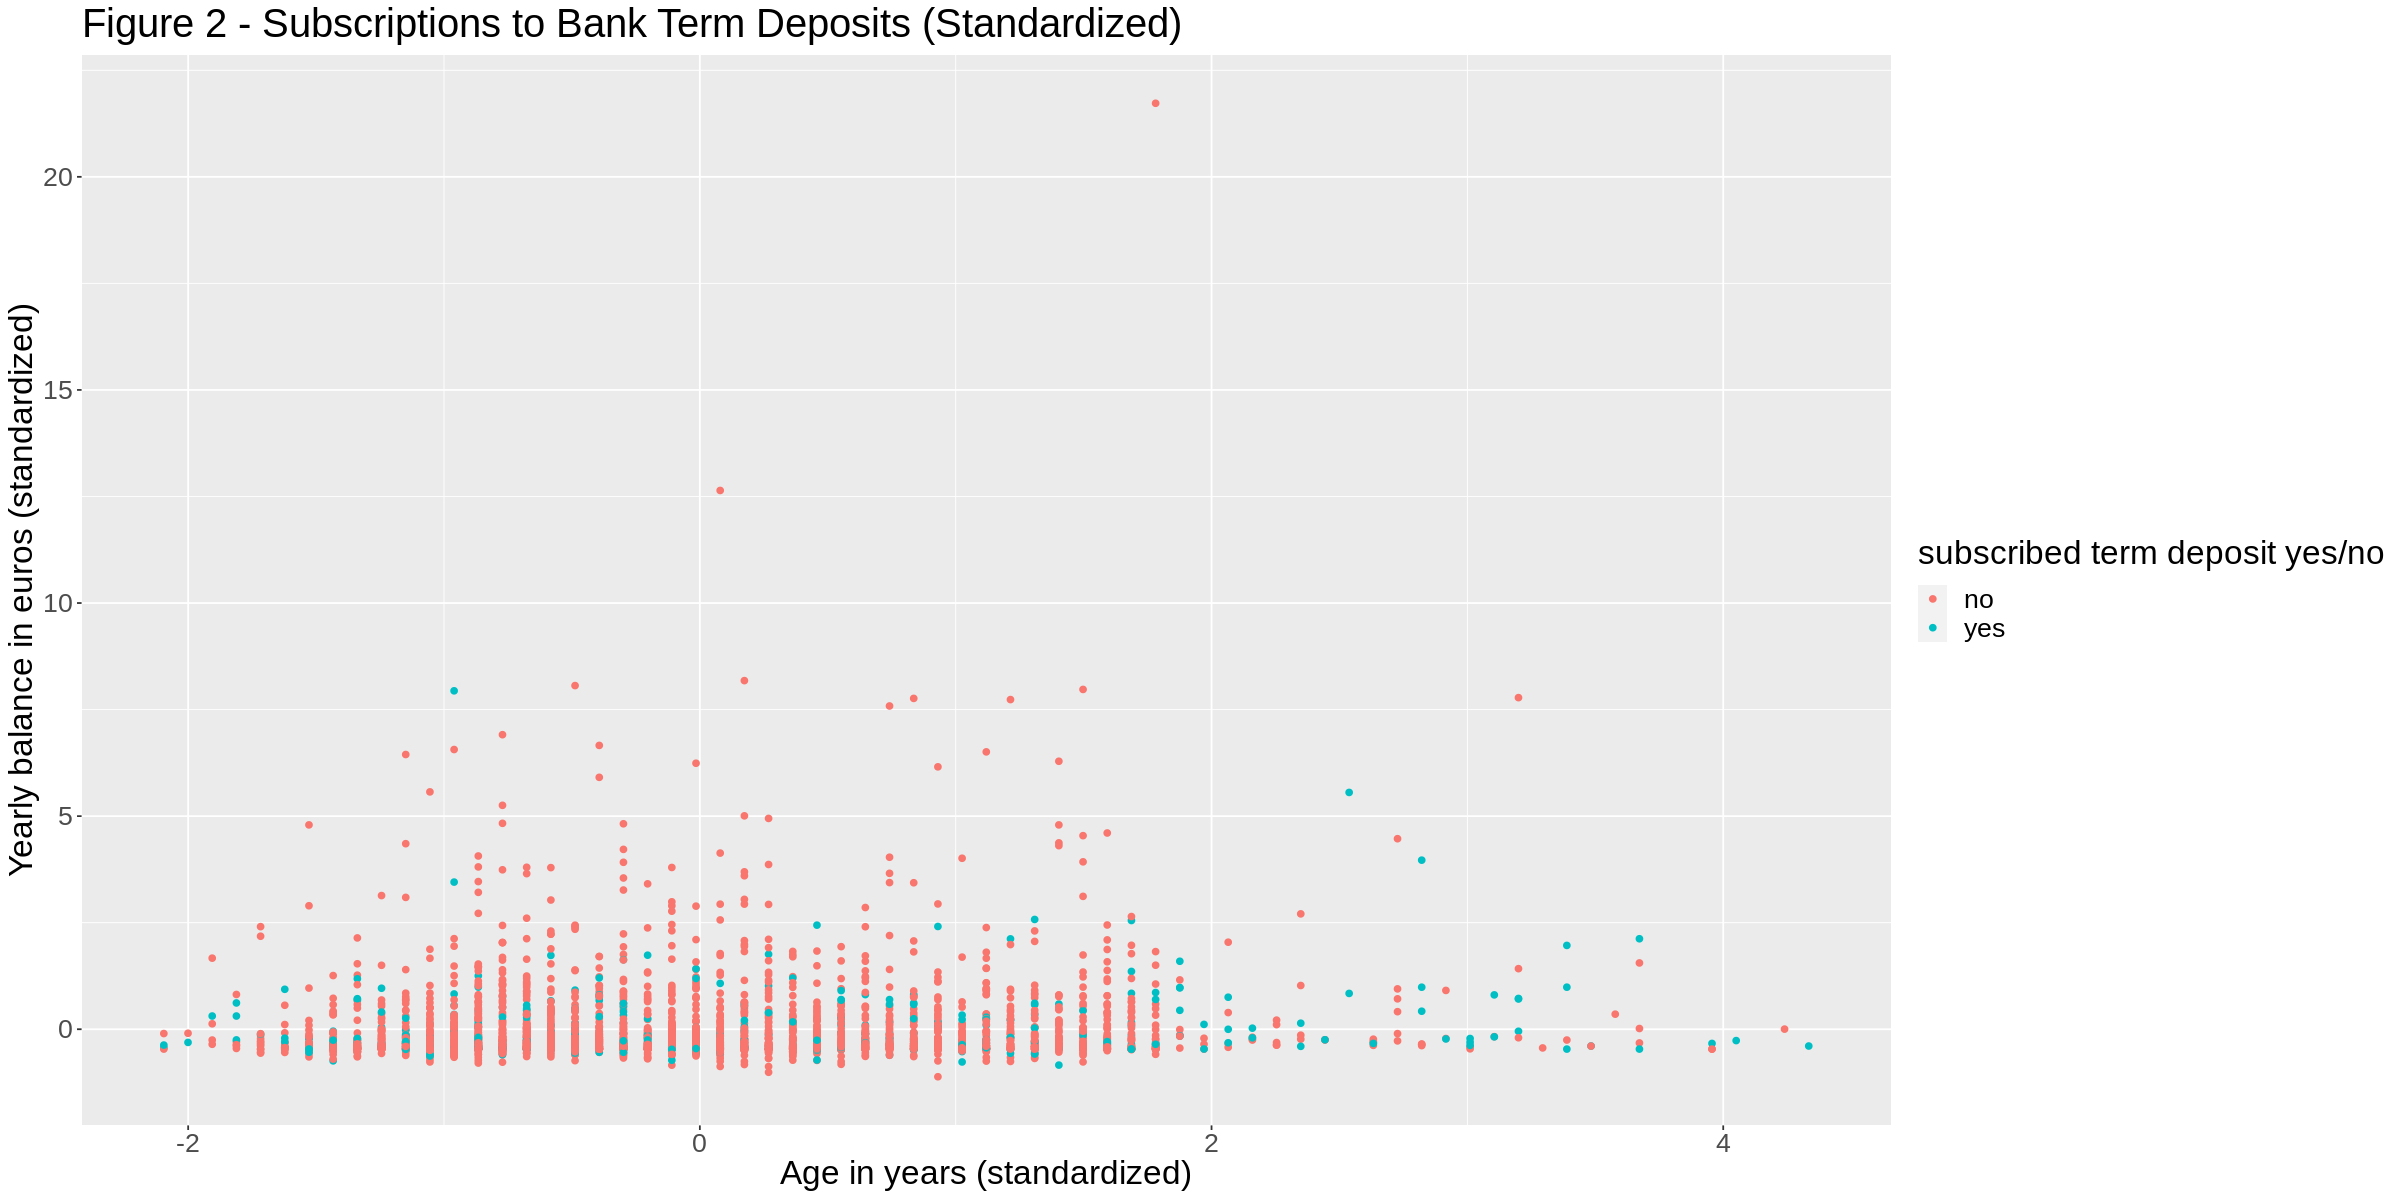

In [23]:
# Plot of the scaled age and balance data with the 
# factor y colored on every single points.

options(repr.plot.width = 20, repr.plot.height = 10) 
scaled_age_vs_balance_plot <- scaled_bank %>%
    ggplot(aes(x = age, y = balance)) +
    geom_point(aes(colour = y)) + 
    labs(x = "Age in years (standardized)", y = "Yearly balance in euros (standardized)",
        colour = "subscribed term deposit yes/no") +
    theme(text = element_text(size = 20)) +
    ggtitle("Figure 2 - Subscriptions to Bank Term Deposits (Standardized)")
scaled_age_vs_balance_plot

In [12]:
# We create our K-nearest neighbour classifier with the training set.
# Here we first randomly choose K=10 and run the process to make sure
# nothing is broken; we will perform cross-validation later and choose
# a better K value.

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 10) %>%
    set_engine("kknn") %>%
    set_mode("classification")

bank_fit <- workflow() %>%
    add_recipe(bank_recipe_scaled) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)

bank_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~10, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1208726
Best kernel: rectangular
Best k: 10

**Table 4 - Accuray of K=10 Model**

In [13]:
# We predict y for the testing set using our model of K=10
bank_test_predictions <- predict(bank_fit, bank_test) %>%
    bind_cols(bank_test)
head(bank_test_predictions)

# We calculate the accuracy of the model K=10, and the accuracy is 88.2%
bank_prediction_accuracy <- bank_test_predictions %>%
    metrics(truth = y, estimate = .pred_class)
bank_prediction_accuracy

.pred_class,age,balance,y
<fct>,<dbl>,<dbl>,<fct>
no,30,1476,no
no,36,307,no
no,41,221,no
no,43,-88,no
no,39,9374,no
no,31,132,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.89636847
kap,binary,0.03451376


**Table 5 - 5-Fold Cross Validation**

In [14]:
# We would like to choose a better K value for our K-neighbour classification model,
# so we perform the cross-validation method on our training set.
# We choose to perform 5-fold cross-validation because 10-fold is too time consuming.
bank_vfold <- vfold_cv(bank_train, v = 5, strata = y)

# Instead of specifying a specific K value we insert tune() to keep it as a changing parameter
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
knn_tune

# Here we perform the workflow again with cross-validation method to calculate an accuracy for
# each K value in a reasonable range, and we pick the K value that gives best accuracy
knn_results <- workflow() %>%
      add_recipe(bank_recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = bank_vfold, grid = 10) %>%
      collect_metrics()
head(knn_results)

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7953945,5,0.010344750,Model01
2,roc_auc,binary,0.5248015,5,0.012269340,Model01
4,accuracy,binary,0.8537772,5,0.003131732,Model02
4,roc_auc,binary,0.5459095,5,0.016252901,Model02
5,accuracy,binary,0.8691074,5,0.002649035,Model03
5,roc_auc,binary,0.5354630,5,0.020595200,Model03


Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”


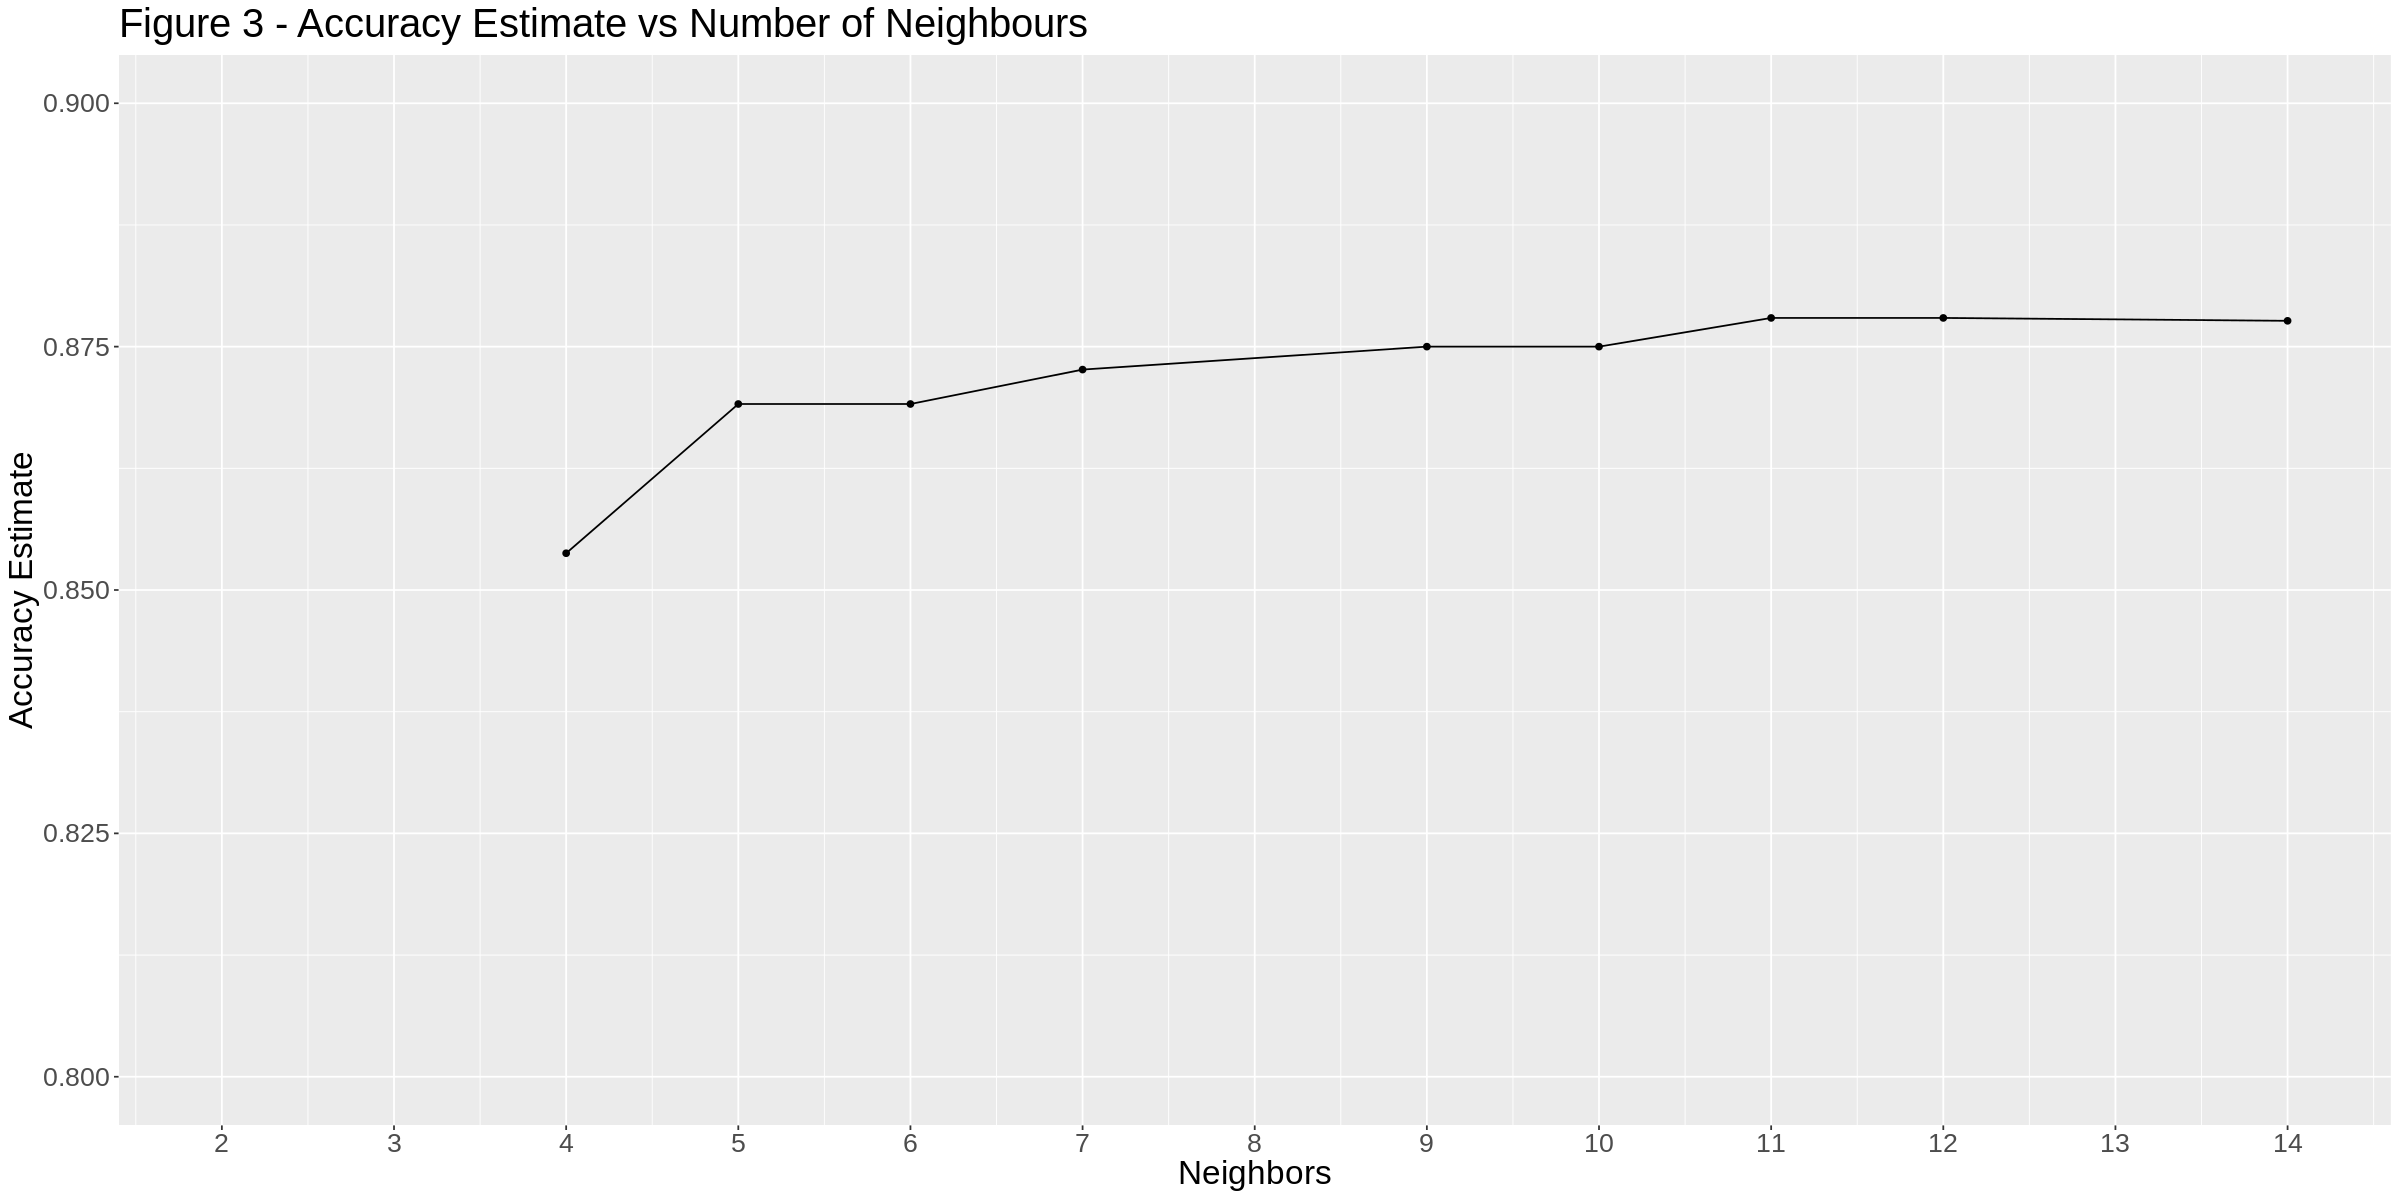

In [15]:
# Filter the accuracy from the .metric column
accuracies <- knn_results %>% 
      filter(.metric=="accuracy")

# Create a plot using the accuracies dataset with K value on the x-axis and estimated accuracy on the y-axis
options(repr.plot.width = 20, repr.plot.height = 10) 
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.8, 0.9)) + # adjusting the y-axis
ggtitle("Figure 3 - Accuracy Estimate vs Number of Neighbours") +
theme(text = element_text(size = 20)) 
accuracy_versus_k

**Table 6 - Accuracy of Model**

In [16]:
# From the graph above, K=12 gives the best accuracy, so we perform the whole K-neighbours classification process with K=12
# The smallest RMSPE occurs at this K value, so we know that it is best

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) %>%
    set_engine("kknn") %>%
    set_mode("classification")

bank_fit <- workflow() %>%
    add_recipe(bank_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)

bank_test_predictions <- predict(bank_fit, bank_test) %>%
    bind_cols(bank_test)
head(bank_test_predictions)

bank_prediction_accuracy <- bank_test_predictions %>%
    metrics(truth = y, estimate = .pred_class)
bank_prediction_accuracy

# From bank_prediction_accuracy, our model of using age and balance to predict y have accuracy of 88.4%

.pred_class,age,balance,y
<fct>,<dbl>,<dbl>,<fct>
no,30,1476,no
no,36,307,no
no,41,221,no
no,43,-88,no
no,39,9374,no
no,31,132,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.896368468
kap,binary,-0.005205123


**Results**<br/>
The K-nearest neighbors algorithm was repeated with K=12. The model we created to predict whether or not a new client will subscribe to a bank term deposit based on their age and bank balance was found to have an accuracy of 88.4%.

**Discussion: Expected Outcomes & Significance**

The main conclusion of our findings is that most people do not subscribe to a term deposit based on their age or balanace. It is unexpected to see such a strong bias against subscribing throughout all of the data based on our two selected variables. However, studying this data provides insights of clientele behaviour to the bank. A company should always understand their consumer demographic and work accordingly to their actions and needs. Our results may cause the bank to reconsider its marketing strategies.

Perhaps there are other factors that cause clientele to subscribe to a term deposit, and this data provides a stepping stone to finding that specific demographic. If age and balance do not play a positive role, what does? The bank may work with these findings to figure out their target market to know who subscribes to term deposits and why they do it.

**References**